# `check_shift.ipynb`

## Introduction

This notebook aims at vizualizing the effects of misaligned field magnitudes with respect to their respective Fourier transform magnitudes.

This scenario is most likely to happen when dealing with experimental records.

## Imports and synthetic data loading (speckle)

Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import speckleret

Load pre-computed example speckle field (computed from a GRIN fiber simulation) and compute its Fourier transform

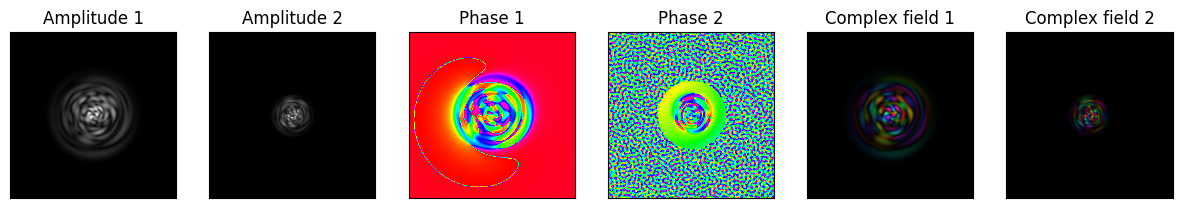

In [2]:
field = np.load('../imports/grin_speckle_example.npy')
# field = speckleret.transforms.pad_img(field, pad=0.5)
ft_field = speckleret.transforms.fourier_transform(field, pad=None)
_ = speckleret.plots.compare_complex_fields(field, ft_field, remove_ticks=True)

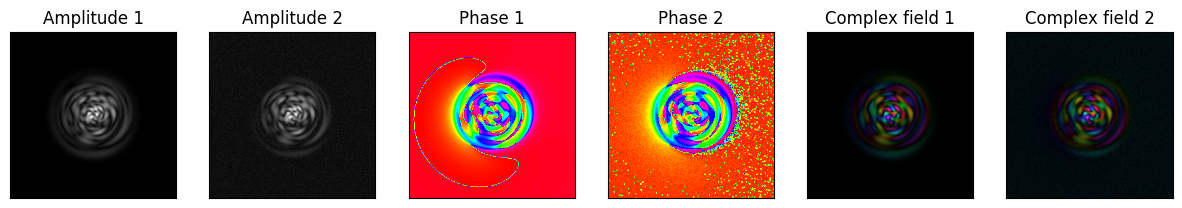

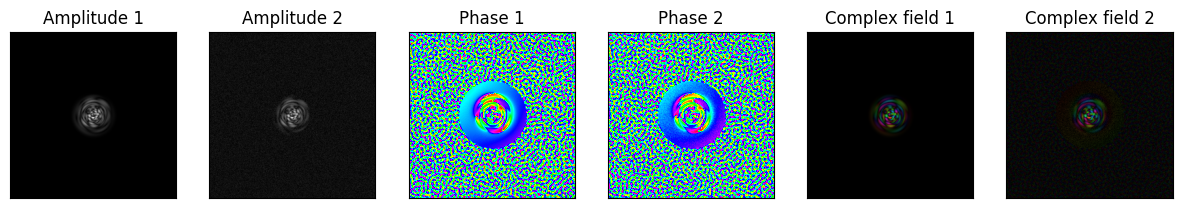

In [3]:
noisy_field = speckleret.noise.add_complex_noise(field, intens_noise_std=0.005, phase_noise_std=1064e-9/60, wavelength=1064e-9)
noisy_ft = speckleret.noise.add_complex_noise(ft_field, intens_noise_std=0.005, phase_noise_std=1064e-9/60, wavelength=1064e-9)

_ = speckleret.plots.compare_complex_fields(field, noisy_field, remove_ticks=True)
_ = speckleret.plots.compare_complex_fields(ft_field, noisy_ft, remove_ticks=True)

## Run phase retrieval on the computed fields

Let's first generate the support constraint from thresholding and visualize the support

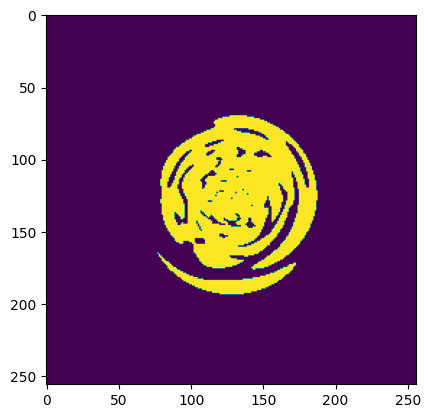

In [4]:
support = speckleret.supports.threshold_support(field, threshold=0.01)
plt.imshow(support)
plt.show()

# support = speckleret.supports.disk_support(field, radius=65)
# supported_field = field * support
# _ = speckleret.plots.complex_imshow(supported_field, remove_ticks=True)

## Run phase retrieval

Phase error:
  - Mean: -0.12871 rad
  - Std: 0.21439 rad
  - Lambda / X: 29.30689 rms


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

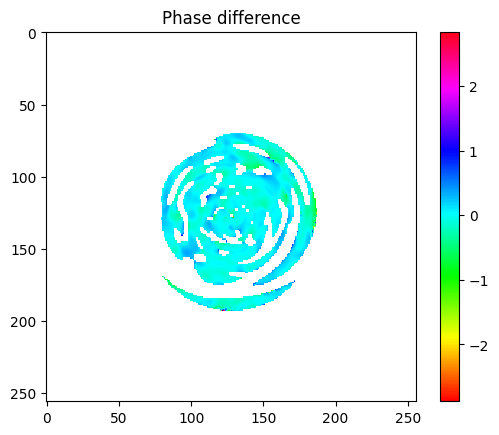

In [12]:
max_iter = 300
beta = 0.8

x = np.abs(field) * np.exp(1j * 2 * np.pi * np.random.rand(*field.shape))

mse = []
quality = []
for i in range(max_iter):
    metric = speckleret.cupy.metrics.mse(speckleret.cupy.transforms.fourier_transform(cp.array(x)), np.abs(cp.array(ft_field)))
    q = speckleret.cupy.metrics.quality(cp.array(x[support]), cp.array(field[support]), inversed=True)
    mse.append(metric)
    quality.append(q)

    # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.SF(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.HIO(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.DM(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.ASR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.HPR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    x = speckleret.cupy.retrievalmath.RAAR(x=cp.array(x), magnitude_S=cp.array(np.abs(field)), magnitude_M=cp.array(np.abs(ft_field)), support=cp.array(support), beta=beta)

    if i == 0:
        q_best, x_best = q, x
    else:
        if q < q_best:
            q_best, x_best = q, x
            
            
speckleret.plots.phase_difference(cp.asnumpy(x_best), cp.asnumpy(field), cp.asnumpy(support))

Generate the support of the object field

Quality: 0.9755117836896934
Pearson: 0.9628626230479208
Best Quality: 0.9841037702341839
Best Pearson: 0.9635531647201081
Quality: 0.9369241267151132
Pearson: 0.9628626230479208
Best Quality: 0.9586892341116685
Best Pearson: 0.9635531647201081


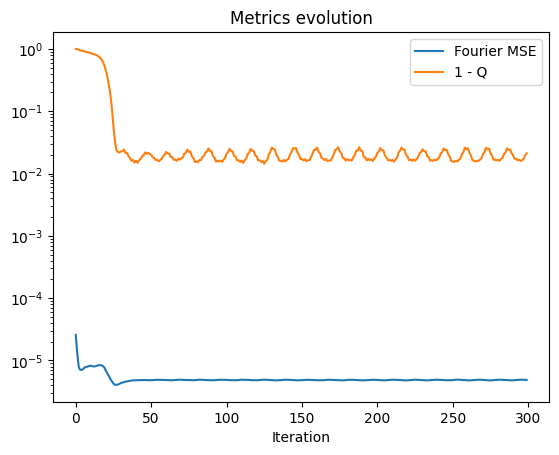

In [23]:
print(f"Quality: {speckleret.metrics.quality(cp.asnumpy(x[support]), cp.asnumpy(field[support]))}")
print(f"Pearson: {speckleret.metrics.pearson(cp.asnumpy(x[support]), cp.asnumpy(field[support]))}")
print(f"Best Quality: {speckleret.metrics.quality(cp.asnumpy(x_best[support]), cp.asnumpy(field[support]))}")
print(f"Best Pearson: {speckleret.metrics.pearson(cp.asnumpy(x_best[support]), cp.asnumpy(field[support]))}")
print(f"Quality: {speckleret.metrics.quality(cp.asnumpy(np.exp(1j * np.angle(x[support]))), cp.asnumpy(np.exp(1j * np.angle(field[support]))))}")
print(f"Pearson: {speckleret.metrics.pearson(cp.asnumpy(x[support]), cp.asnumpy(field[support]))}")
print(f"Best Quality: {speckleret.metrics.quality(cp.asnumpy(np.exp(1j * np.angle(x_best[support]))), cp.asnumpy(np.exp(1j * np.angle(field[support]))))}")
print(f"Best Pearson: {speckleret.metrics.pearson(cp.asnumpy(x_best[support]), cp.asnumpy(field[support]))}")

plt.figure()
plt.plot([m.get() for m in mse], label='Fourier MSE')
plt.plot([q.get() for q in quality], label='1 - Q')
plt.yscale('log')
plt.title('Metrics evolution')
plt.xlabel('Iteration')
plt.legend()

In [21]:
mse

[array(2.58011147e-05),
 array(1.29164593e-05),
 array(7.81615606e-06),
 array(7.05756228e-06),
 array(7.03848646e-06),
 array(7.34715896e-06),
 array(7.74520054e-06),
 array(7.89329697e-06),
 array(7.99303063e-06),
 array(8.20368894e-06),
 array(8.24432252e-06),
 array(8.07062791e-06),
 array(8.03446607e-06),
 array(8.06966218e-06),
 array(8.26199363e-06),
 array(8.33559435e-06),
 array(8.46479003e-06),
 array(8.34572529e-06),
 array(8.14422035e-06),
 array(7.68029218e-06),
 array(6.80554909e-06),
 array(6.17035404e-06),
 array(5.58897581e-06),
 array(5.01967171e-06),
 array(4.60620684e-06),
 array(4.25855251e-06),
 array(4.09005593e-06),
 array(4.05432085e-06),
 array(4.11638952e-06),
 array(4.22799023e-06),
 array(4.34612657e-06),
 array(4.42192304e-06),
 array(4.50087059e-06),
 array(4.56684845e-06),
 array(4.63023116e-06),
 array(4.67693016e-06),
 array(4.72468281e-06),
 array(4.75896486e-06),
 array(4.79837751e-06),
 array(4.81254937e-06),
 array(4.83933952e-06),
 array(4.8356666